In [9]:
%run init_notebook.py

In [10]:
import pymc as pm

In [11]:
from src.utils import load_pd_df, save_pd_df, get_dt_index, pd_join_freq
from src.processing import pd_groupby, pd_join_dfs
from src.pymc_modelling import get_samp

In [12]:
# load

In [13]:
hhp = load_pd_df('hhp_processed.feather')

In [14]:
infl = get_dt_index(load_pd_df('de_inf_prepro.csv')).sort_index()
inlf = infl.drop(['cpi_DE', 'cpi_FR', 'is_train'], axis=1)

In [19]:
topics = load_pd_df('lda_topics_smooth.feather')

In [222]:
df = hhp.set_index('date_recorded')[['date_forecast', 'pi_exp_WY', 'pi_perc_WY', 'delta_pe_WY', 'hhinc_delta', 'id']].copy()

In [223]:
df = df.join(topics['D_inflation_s'])

In [224]:
df['W'] = df.index.to_period('W').to_timestamp()

In [244]:
df = pd_join_dfs(
    [
        hhp.set_index('date_recorded')[['date_forecast', 'pi_exp_WY', 'pi_perc_WY', 'delta_pe_WY', 'hhinc_delta', 'id']],
        topics[['D_inflation_s']],
    ],
    index_name='date_recorded'
).copy()

# News data

In [245]:
sub = df[['D_inflation_s', 'pi_perc_WY', 'hhinc_delta', 'id',]].drop_duplicates().copy().reset_index()
sub = sub.loc[sub[['pi_perc_WY', 'D_inflation_s']].dropna().index]

In [247]:
sub = sub.set_index(['date_recorded', 'id'])

In [248]:
filt = sub.pi_perc_WY.unstack().count() >= 9
len(filt[filt])

323

In [249]:
sub = sub.loc[sub.index.get_level_values(1).isin(filt[filt].index)]

In [251]:
A = sub.pi_perc_WY.unstack().copy()

In [155]:
pi_perc = [list(A[x].dropna().values) for x in A]
pi_perc = np.array([ x + list([0] * (A.count().max() - len(x))) for x in pi_perc]).T

<AxesSubplot: xlabel='date_recorded'>

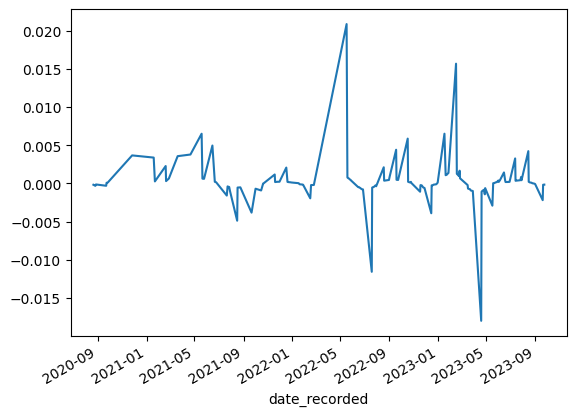

In [266]:
ser = sub.reset_index().set_index('date_recorded').D_inflation_s.drop_duplicates()
ser.diff().plot()

In [156]:
ser = sub.reset_index().set_index('date_recorded').D_inflation_s.drop_duplicates()
news = [list(ser.values[list(A.reset_index(drop=True)[x].dropna().index)]) for x in A]
news = np.array([x + list([0] * (A.count().max() - len(x))) for x in news]).T

In [157]:
pi_perc.shape, news.shape

((12, 323), (12, 323))

In [179]:
with pm.Model() as mod:
    
    # beta_mean = pm.Normal("beta_mean", 0, 1, shape=pi_perc.shape[1])
    # beta_sigma = pm.HalfNormal("beta_sigma", 0, 1, shape=pi_perc.shape[1])
    
    alpha = pm.Normal("alpha", mu=0, sigma=1, shape=pi_perc.shape[1])
    beta = pm.Normal("beta", 0, 1) #mu=beta_mean, sigma=beta_sigma, shape=pi_perc.shape[1])
    
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    mu = pm.Deterministic('mu', alpha + beta * news)
    pm.Normal('likelihood', mu=mu, sigma=sigma, observed=pi_perc)
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample() #nuts_sampler="numpyro", chains=4)

Sampling: [alpha, beta, likelihood, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


''

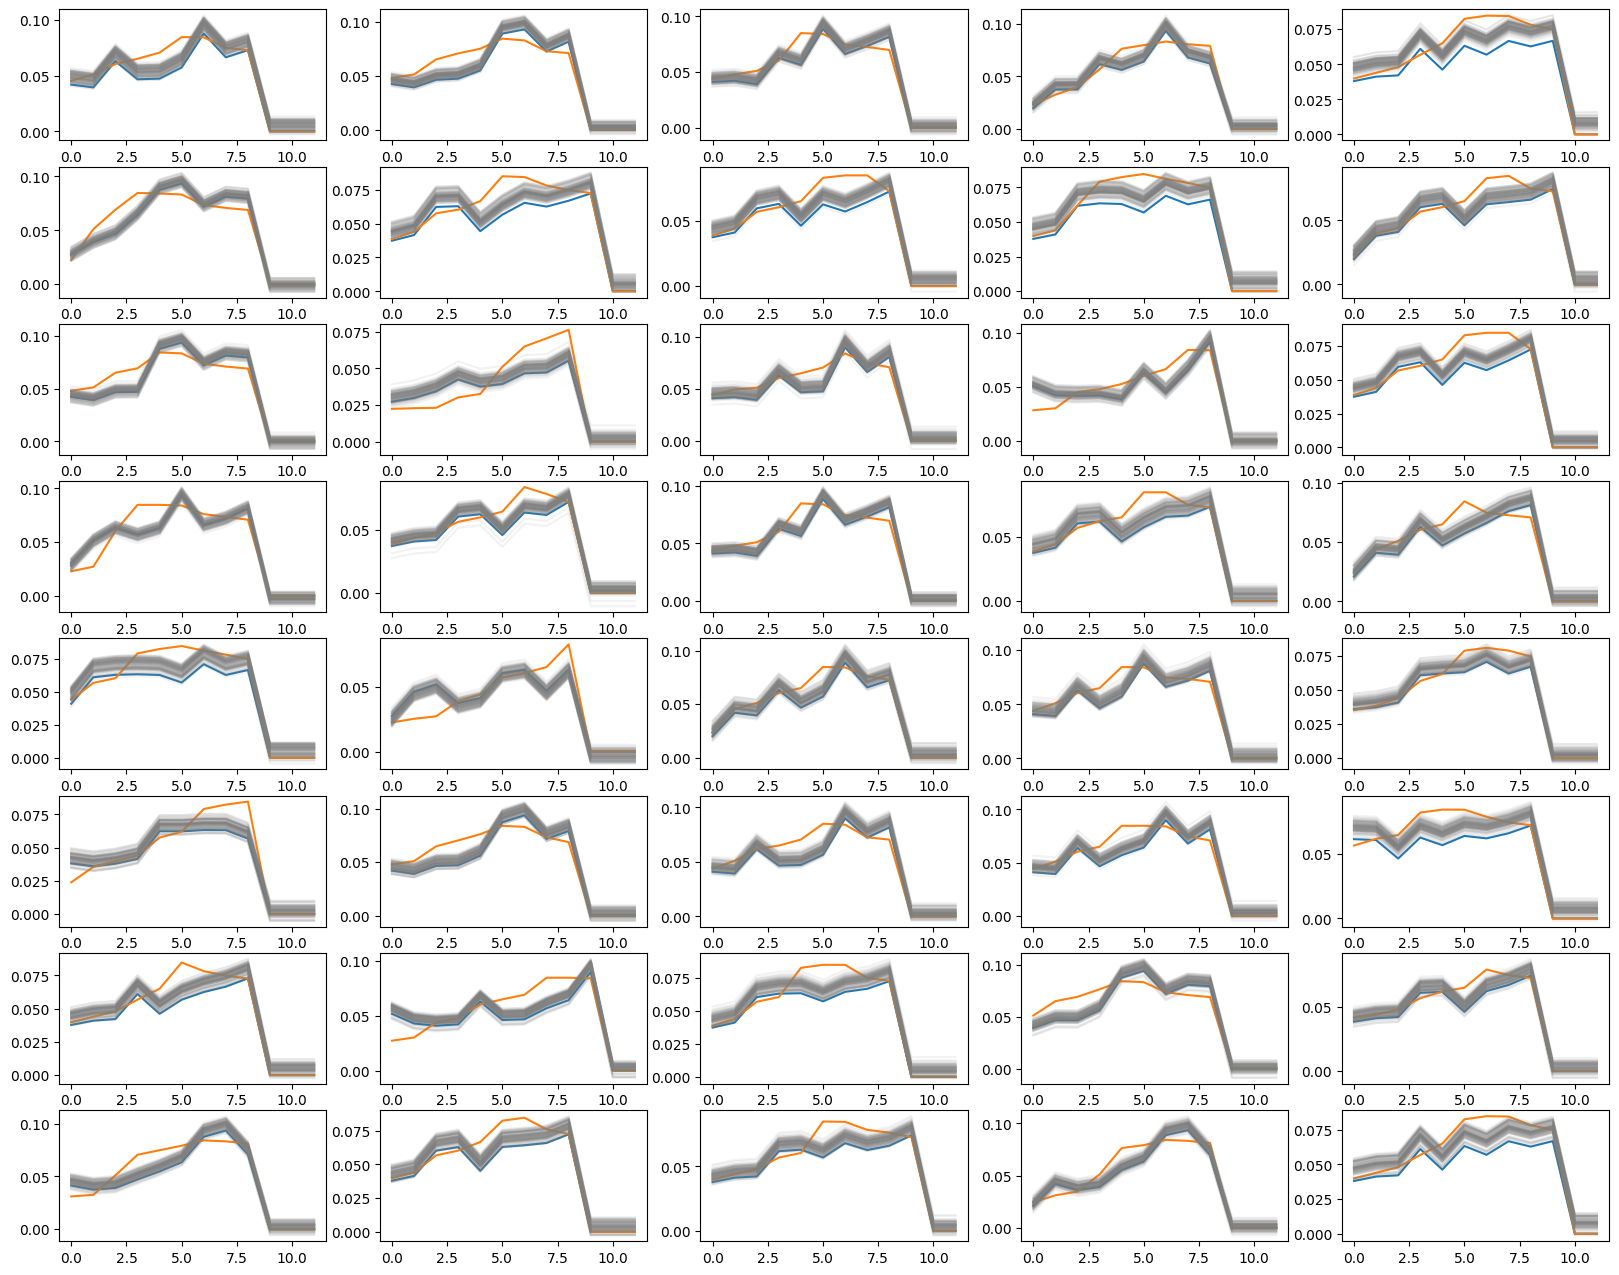

In [180]:
N = 40
cols = 5
fig, axes = plt.subplots(int(np.ceil(N/cols)), cols, figsize=(20, np.ceil(N/cols) * 2))
for i, ax in zip(np.random.randint(0, pi_perc.shape[1], min(pi_perc.shape[1], N)), axes.ravel()):
    ax.plot(news[:,i].T)
    ax.plot(pi_perc[:, i].T)
    ax.plot(trace.posterior['mu'].values[0, get_samp(500), :, i].T, alpha=.1, color='grey'),
;

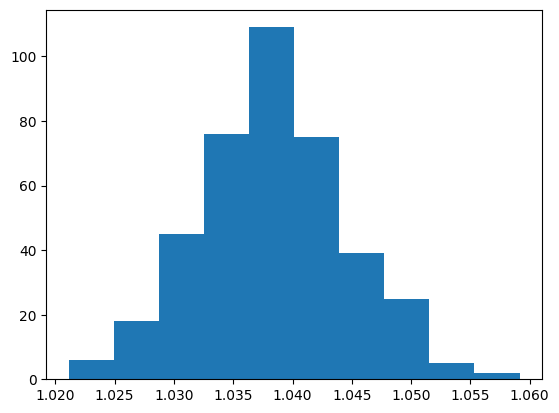

In [187]:
plt.hist(trace.posterior['beta'][:, get_samp(1_000)].values.reshape(4*100));

In [181]:
plt.hist(
    trace.posterior['beta'][:, get_samp(1_000), :].values.reshape(4*100, pi_perc.shape[1]) #.mean(axis=0), 
    bins='fd',
);

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2119373762.py, line 2)